In [52]:
import scipy.io as sio
import pandas as pd
import numpy as np
import torch
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tqdm
import torch.nn as nn


In [25]:
training_videos_path = Path('Avenue Dataset') / 'training_vol'

In [26]:
training_videos_path / 'vol01.mat'

WindowsPath('Avenue Dataset/training_vol/vol01.mat')

In [27]:
videodata = sio.loadmat(str(training_videos_path / 'vol01.mat'))  

In [46]:
videodata = videodata['vol']

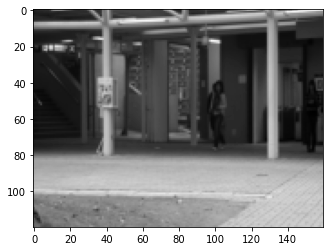

In [34]:
plt.imshow(video1[..., 0], cmap = 'gray')

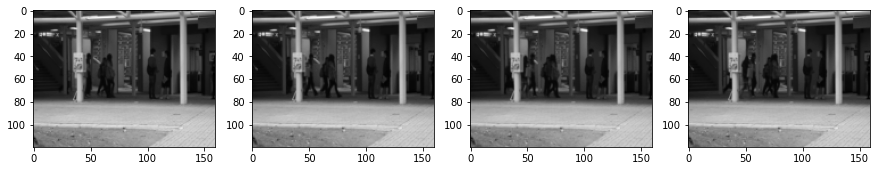

In [39]:
plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.imshow(video1[..., 0], cmap = 'gray')
plt.subplot(1,4,2)
plt.imshow(video1[..., 4], cmap = 'gray')
plt.subplot(1,4,3)
plt.imshow(video1[..., 8], cmap = 'gray')
plt.subplot(1,4,4)
plt.imshow(video1[..., 12], cmap = 'gray')


In [49]:
def generate_stride_set(video_array, stride_size = 1, window_length = 10):

    end = video_array.shape[-1] - window_length
    windows = []
    for i in tqdm.tqdm(range(0, end, stride_size)):
        windows.append(video_array[..., i:i+window_length])
    return np.array(windows)
    



In [50]:
stride_1_set = generate_stride_set(videodata)
stride_3_set = generate_stride_set(videodata, stride_size=2)
stride_2_set = generate_stride_set(videodata, stride_size=3)

100%|██████████| 452/452 [00:00<?, ?it/s]


In [80]:
class SpatialEncoder(nn.Module):

    def __init__(self):
        super(SpatialEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels= 128, kernel_size= 11, stride=4)
        self.conv2 = nn.Conv2d(in_channels= 128, out_channels= 64, kernel_size=5, stride=2)

    def forward(self, X):

        slices = []
        x = torch.unsqueeze(X, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


In [81]:
first_slice = stride_1_set[0]

In [82]:
first_slice = torch.Tensor(first_slice)

In [83]:
first_slice = first_slice.permute([2,0,1])

In [84]:
first_slice.shape

torch.Size([10, 120, 160])

In [85]:
spatial_encoder = SpatialEncoder()

In [88]:
spatial_encoder(first_slice).shape

torch.Size([10, 64, 12, 17])

In [94]:
test = torch.rand((10,227,227))

In [95]:
spatial_encoder(test).shape

torch.Size([10, 64, 26, 26])

In [96]:
from conv_lstm import ConvLSTM

In [98]:
clstm1 = ConvLSTM(64, 64, (3,3), 1, True, True, False)

In [104]:
_, last_states = clstm1(torch.unsqueeze(spatial_encoder(test), 0))

In [119]:
 h = last_states[0][1]  # 0 for layer index, 0 for h index

In [117]:
h.shape

torch.Size([1, 64, 26, 26])

In [120]:
x = torch.rand((32, 10, 64, 128, 128))

In [122]:
convlstm = ConvLSTM(64, 16, (3,3), 1, True, True, False)

In [123]:
_, last_states = convlstm(x)

In [129]:
h = last_states[0][1]  # 0 for layer index, 0 for h index

In [130]:
h.shape

torch.Size([32, 16, 128, 128])